In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#torch.multiprocessing.set_start_method("spawn")
import resnet 
from sklearn.model_selection import KFold

import os
import numpy as np
import pandas as pd
from utils import progress_bar
from skimage import transform as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
#test = pd.read_json(BASE_dir + 'test.json')

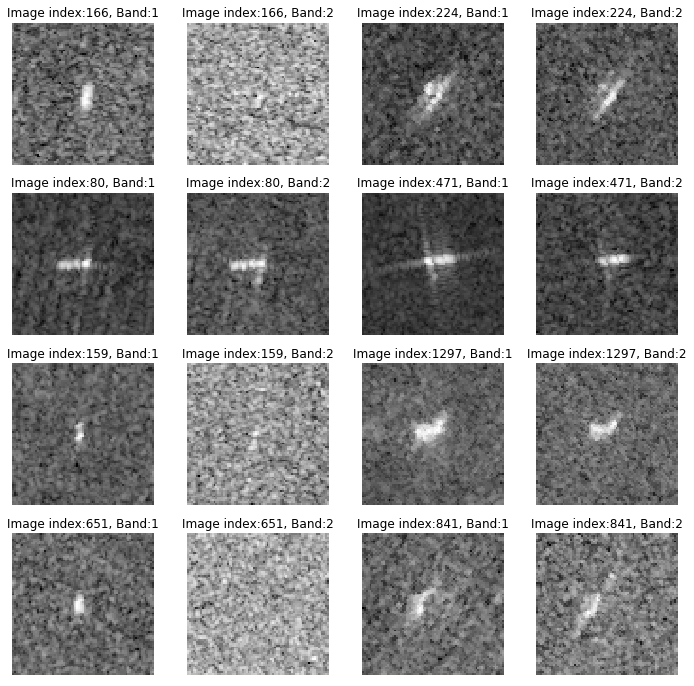

In [3]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [3]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            
            #rotate, scale, shear, translation
#             if self.test is False:
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 scale1 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 scale2 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 #shear = np.random.uniform(-np.pi/18, np.pi/18)
#                 #tran = np.random.uniform(-5, 5)
#                 #aug = tf.AffineTransform(shear = shear, translation=tran, scale= (scale1, scale2))
#                 aug = tf.AffineTransform(scale= (scale1, scale2))
#                 img = tf.warp(img, inverse_map=aug)
            
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
            
            if self.test is False:
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=1).copy()
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=2).copy()
                #scale = np.exp(np.random.uniform(np.log(1/1.1), np.log(1.1)))
                #aug = tf.AffineTransform(scale= (scale, scale))
                #img = tf.warp(img, inverse_map=aug)
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 angle = np.random.choice([0, 30,60],size=1)
#                 img = tf.rotate(img,angle=angle,resize=False)
                rotate = np.random.randint(4, size=1)
                if rotate:
                    img = np.rot90(img,k=rotate,axes=(1,2)).copy()
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

def data_aug(X, y):
    
    X_rot_30 = []
    X_rot_60 = [] 
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_30.append(tf.rotate(i,angle=30,resize=False))
        X_rot_60.append(tf.rotate(i,angle=60,resize=False))
        
    X_rot_30 = np.stack(X_rot_30)
    X_rot_60 = np.stack(X_rot_60)
    ch_y = np.concatenate((y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
    return ch_X, ch_y


def data_aug2(X, y):    
    X_rot_90 = []
    X_rot_180 = []
    X_rot_270 = []
    X_rot_90_hflip = []
    X_rot_270_hflip = []
    
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_90.append(tf.rotate(i,angle=90,resize=False))
        X_rot_180.append(tf.rotate(i,angle=180,resize=False))
        X_rot_270.append(tf.rotate(i,angle=270,resize=False))
        X_rot_90_hflip.append(np.flip(tf.rotate(i,angle=90,resize=False),2))
        X_rot_270_hflip.append(np.flip(tf.rotate(i,angle=270,resize=False),2))
    
    
    X_rot_90 = np.stack(X_rot_90)
    X_rot_180 = np.stack(X_rot_180)
    X_rot_270 = np.stack(X_rot_270 )
    X_rot_90_hflip = np.stack(X_rot_90_hflip)
    X_rot_270_hflip = np.stack(X_rot_270_hflip)
    
    ch_y = np.concatenate((y,y,y,y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v,X_rot_90,X_rot_180,X_rot_270,X_rot_90_hflip,X_rot_270_hflip))
    return ch_X, ch_y

train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [6]:
# train_index=list(range(1300))
# val_index= list(range(1300,1604))
train_index=list(range(304,1604)) 
val_index= list(range(304))
# train_X[train_index].shape
# train_index= list(range(1604))
# data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
# train_index = np.where(data.inc_angle > 0)[0]
# val_index = np.where(data.inc_angle <= 0)[0]

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))
train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

## add augmentation 

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))

# train_X_af,train_y_af = data_aug(train_X[train_index], train_y[train_index])
# train_mean, train_std = transform_compute(train_X_af)
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X_af, label=train_y_af, transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)


#without na angle data
# train_X_del = train_X[data.inc_angle!='na',:,:,:]
# train_y_del = train_y[data.inc_angle!='na']

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X_del))
# # # train_index=list(range(284,1471)) 
# # # val_index= list(range(284))

# train_mean, train_std = transform_compute(train_X_del[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])
# af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])
# #af_train_X, af_train_y = data_aug2(train_X_del[train_index], train_y_del[train_index])
# #af_train_X, af_train_y = train_X_del[train_index], train_y_del[train_index]

# train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)


# train_index=list(range(1604)) 
# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))
# train_mean, train_std = transform_compute(train_X[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])


In [4]:
train_X_del = train_X
train_y_del = train_y

In [84]:
# data.columns
# data.inc_angle!='na'
# data['is_iceberg'][np.where(data.inc_angle=='na')[0]]
# seed= np.random.RandomState(1)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X[np.where(data.inc_angle!='na')[0]]))
# train_index
# train_X[np.where(data.inc_angle=='na')[0]].shape

(133, 3, 75, 75)

In [7]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    val_loss=0
    best_acc = 0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    best_epoch =0
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.2f | Acc: %.2f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'resnet50_ang_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'resnet50_ang_loss.pth')
            if loss_avg/total >val_loss:
                e_s=0

#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,best_epoch

    return best_val_loss,best_acc,best_epoch
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total 

In [ ]:
#for i in range(20):
resnet34 = resnet.resnet34(pretrained=False)
net= resnet34
net.fc = nn.Linear(512 * 1, 2)

# drop1=0.5
# drop2=0.5
# net.fc = nn.Sequential(
#     nn.Linear(512 * 1,256 * 1),
#     nn.BatchNorm1d(256 * 1),
#     nn.ReLU(True),
#     nn.Dropout(drop1),
#     nn.Linear(256 * 1,256 * 1),
#     nn.BatchNorm1d(256 * 1),
#     nn.ReLU(True),
#     nn.Dropout(drop2),
#     nn.Linear(256 * 1,2)
# )

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002, nesterov= True)
# scheduler = MultiStepLR(optimizer, [25, 50,75], gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.0001)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

temp = train(epoch=100,early_stopping=20)
print(temp)
if temp[0]<0.185 and temp[1]>=93.5:
    break
    #before without na
    #val loss & acc: 0.22457916034480271, 91.1864406779661
    #val loss & acc: 0.21438626758122847, 91.86440677966101
    #val loss & acc: 0.22149639276124664, 91.52542372881356
    
    #without na add all augmentation
    #(0.3054375237327511, 89.83050847457628, 0) 


In [34]:
seed= np.random.RandomState(7791)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for num, (train_index, val_index) in enumerate(spliter.split(train_X)):
    if num == 0:
        break

train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])
train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

In [5]:
os.listdir('resnet34_save_model')

['resnet34_acc34_2.pth',
 'resnet34_acc21_3.pth',
 'resnet34_acc13_2.pth',
 'resnet34_acc24_2.pth',
 'resnet34_acc24_4.pth',
 'resnet34_acc03_3.pth',
 'resnet34_acc03_4.pth',
 'resnet34_acc24_1.pth',
 'resnet34_acc13_3.pth',
 'resnet34_acc34_4.pth',
 '.ipynb_checkpoints',
 'resnet34_acc34_1.pth',
 'resnet34_acc14_0.pth',
 '1resnet34_acc10_1.pth',
 '1resnet34_acc10_3.pth',
 'resnet34_acc14_4.pth',
 'resnet34_acc54_3.pth',
 'resnet34_acc21_1.pth',
 'resnet34_acc34_3.pth',
 'resnet34_acc13_0.pth',
 'resnet34_acc03_0.pth',
 'resnet34_acc21_0.pth',
 'resnet34_acc13_1.pth']

In [38]:
##For continue training
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34
net.load_state_dict(torch.load('resnet34_save_model/1resnet34_acc10_3.pth'))

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0002, nesterov= True)
#scheduler = MultiStepLR(optimizer, [50,100], gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.0001)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=150)

# test_set = pd.read_json(BASE_dir + 'test.json')
# test_X = raw_to_numpy(test_set)
# test_X.shape 
# fake_label = np.zeros(len(test_X))

# test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

# test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)
# result = []
# for i in range(10):
#     train(epoch=1)

#     prob = [] 
#     net.eval()
#     for k, (val_x, val_y) in enumerate(test_loader):
#         if use_cuda:
#             val_x, val_y = val_x.cuda(), val_y.cuda()
#         x = Variable(val_x)
#         y = Variable(val_y)
#         out = net(x)
#         #prevent overflow
#         temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
#         ans= temp[:,1]/(temp.sum(axis=1))
#         prob.append(ans)
#         #print(out.size())
#         progress_bar(k, len(test_loader))
#     result.append(np.concatenate(prob))


This is epoch:1
[=================== 41/41 =================>.]  Step: 31ms | Tot: 3s244ms | Loss: 0.162 | Acc: 93.453% (1199/1283)
[=================== 6/6 =============>.......]  Step: 12ms | Tot: 192ms | Loss: 0.155 | Acc: 94.081% (302/321)
save it!

save it!


This is epoch:2
[=================== 41/41 =================>.]  Step: 29ms | Tot: 3s232ms | Loss: 0.146 | Acc: 93.998% (1206/1283)
[=================== 6/6 =============>.......]  Step: 12ms | Tot: 192ms | Loss: 0.157 | Acc: 94.081% (302/321)
save it!

save it!


This is epoch:3
[=================== 41/41 =================>.]  Step: 29ms | Tot: 3s233ms | Loss: 0.162 | Acc: 92.985% (1193/1283)
[=================== 6/6 =============>.......]  Step: 13ms | Tot: 193ms | Loss: 0.153 | Acc: 94.393% (303/321)
save it!

save it!


This is epoch:4
[=================== 41/41 =================>.]  Step: 30ms | Tot: 3s236ms | Loss: 0.153 | Acc: 93.920% (1205/1283)
[=================== 6/6 =============>.......]  Step: 14ms | Tot: 193ms

Process Process-210:
KeyboardInterrupt
Process Process-209:
Process Process-208:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.5/dist-packag

KeyboardInterrupt: 

In [75]:
test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape

(8424, 3, 75, 75)

In [5]:
net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('spec_resnet34_acc.pth'))
# net.load_state_dict(torch.load('resnet34_acc.pth'))
net.cuda()

test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[=================== 132/132 ================>]  Step: 32ms | Tot: 5s788ms


In [31]:
#k =np.stack(result).mean(axis=0)
# #sub.shape
# result[1].shape
# np.concatenate(prob).shape
data['c1'] = data['band_1'].apply(np.array)

In [21]:
sub=pd.DataFrame()
sub['id'] = test['id']
#sub['is_iceberg'] = temp12.mean(axis=1)# np.concatenate(prob)
#sub['is_iceberg'] = np.concatenate(prob)
sub['is_iceberg'] = temp11['is_iceberg']
sub.shape
sub.to_csv('submission111.csv',index=False)

In [41]:
temp= pd.read_csv('submission3.csv') #0.0001 wd one
sub['is_iceberg2'] = temp['is_iceberg']
sub.corr()

,is_iceberg,is_iceberg2
is_iceberg,1.000000,0.886197
is_iceberg2,0.886197,1.000000


In [11]:
#try dropout 0.5 on the last fc
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov= True)
scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=250)


This is epoch:1
[=================== 41/41 =================>.]  Step: 460ms | Tot: 16s242ms | Loss: 4.618 | Acc: 56.231% (731/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 770ms | Loss: 421.466 | Acc: 50.658% (154/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 464ms | Tot: 16s191ms | Loss: 2.397 | Acc: 59.308% (771/1300)
[=================== 5/5 ============>........]  Step: 174ms | Tot: 767ms | Loss: 1032.273 | Acc: 49.342% (150/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s228ms | Loss: 1.995 | Acc: 58.154% (756/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 766ms | Loss: 522.733 | Acc: 59.539% (181/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 469ms | Tot: 16s205ms | Loss: 5.970 | Acc: 52.615% (684/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 9.002 | Acc: 50.000% (152/304)

This

(93.42105263157895, 249)

In [ ]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
#         scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'res34_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                acc= best_acc+ 0.01
                print('loss: Save it!')
                torch.save(net.state_dict(), 'res34_loss.pth')
            if loss_avg/total > val_loss:
                e_s = 0
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss, best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total 


#Try different transformation

result_hist=[]
for rou in range(6):
    ran_num = np.random.randint(10000,size=1)
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X)):
        count =0
        train_X[train_index].shape

        train_mean, train_std = transform_compute(train_X[train_index])
        train_transform = T.Compose([
            T.Normalize(train_mean, train_std)
        ])

        train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
        val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)
        for rep in range(6):
            count+=1
            resnet34 = resnet.resnet34(num_classes=2)
            net= resnet34

            criterion = nn.CrossEntropyLoss()

            #Adam does not perform so good here   
            #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
            optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002, nesterov= True)
            #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
            scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.0001)
            #5e-3 86
            if use_cuda:
                criterion.cuda()
                net.cuda()  

            temp = train(epoch=250,early_stopping=15)
            print(temp)
#             print(temp)
#             if temp[0]<0.185 and temp[1]>=93.5:
#                 break

            #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
            #     cudnn.benchmark = True   
            result_hist.append((rep,temp))
            if  temp[1] >=92.5 and temp[0]<=0.190 and temp[3]<=0.18:
                count=0
                with open("log.txt", "a") as myfile:
                    msg = 'At round {}, fold {}, seed {}, we find a good value with acc: {}, loss: {}\n'.format(rou,
                                                                k,ran_num, temp[1], temp[0])
                    myfile.write(msg)
                cmd = 'cp resnet34_acc.pth resnet34_save_model/1resnet34_acc{}{}_{}.pth'.format(rou,k,rep)
                os.system(cmd)
            if count>=3:
                break

In [7]:
#result_hist

temp11 = pd.DataFrame()

for i in range(5):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load('resnet34_acc%d.pth'%i))
    net.cuda()

    test = pd.read_json(BASE_dir + 'test.json')
    test_X = raw_to_numpy(test)
    test_X.shape 
    fake_label = np.zeros(len(test_X))

    test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

    test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' %i
    temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s494ms
[=================== 132/132 ================>]  Step: 160ms | Tot: 27s661ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s644ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s598ms
[=================== 132/132 ================>]  Step: 161ms | Tot: 27s668ms


In [20]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = result/5
sub.shape
sub.to_csv('submissionll.csv',index=False)

In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, 0:6].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, 0:6].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, 0:6].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg5']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))


In [28]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg5']
sub.shape
sub.to_csv('submission5.csv',index=False)

In [8]:
net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('save_resnet34_acc117.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))
msg = 'is_iceberg%d' %5
temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s704ms


In [ ]:
temp11.iloc[:,0:5]

In [27]:
temp11.corr()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3,is_iceberg4,is_iceberg5,is_iceberg_max,is_iceberg_min,is_iceberg_median,is_iceberg_base,is_iceberg
is_iceberg0,1.000000,0.852644,0.822586,0.648968,0.883101,0.905277,0.682861,0.922862,0.942663,0.905277,0.905900
is_iceberg1,0.852644,1.000000,0.905401,0.754710,0.833295,0.815734,0.821258,0.777728,0.956190,0.815734,0.816630
is_iceberg2,0.822586,0.905401,1.000000,0.771766,0.774018,0.784324,0.847868,0.738630,0.918857,0.784324,0.785453
is_iceberg3,0.648968,0.754710,0.771766,1.000000,0.685649,0.556919,0.940914,0.592617,0.749656,0.556919,0.559032
is_iceberg4,0.883101,0.833295,0.774018,0.685649,1.000000,0.826391,0.685683,0.920097,0.909537,0.826391,0.827514
is_iceberg5,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683
is_iceberg_max,0.682861,0.821258,0.847868,0.940914,0.685683,0.653849,1.000000,0.583326,0.792055,0.653849,0.655435
is_iceberg_min,0.922862,0.777728,0.738630,0.592617,0.920097,0.895245,0.583326,1.000000,0.875356,0.895245,0.895989
is_iceberg_median,0.942663,0.956190,0.918857,0.749656,0.909537,0.896220,0.792055,0.875356,1.000000,0.896220,0.897011
is_iceberg_base,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683


In [11]:
seed= np.random.RandomState(67)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for i in spliter.split(list(range(100))):
    print(i)
    break

(array([ 1,  2,  5,  6,  7,  8,  9, 10, 12, 13, 15, 16, 18, 19, 20, 21, 22,
       23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
       44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62,
       63, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99]), array([ 0,  3,  4, 11, 14, 17, 24, 29, 40, 43, 48, 59, 64, 66, 70, 79, 82,
       83, 93, 97]))


In [24]:
#temp12 = pd.DataFrame()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

#path = ['resnet34_acc34_1.pth', 'resnet34_acc34_2.pth','resnet34_acc34_3.pth','resnet34_acc34_4.pth']
#path = ['resnet34_acc34_1.pth', 'resnet34_acc34_2.pth','resnet34_acc34_3.pth','resnet34_acc34_4.pth']
#os.listdir('resnet34_save_model')

#waitlist=['retrain_1_80.pth','1resnet34_acc10_1.pth','1resnet34_acc10_3.pth']
# waitlist= ['retrain_1_80.pth',
# 'retrain_resnet34_acc03_0.pth',
# 'retrain_resnet34_acc03_3.pth',
# 'retrain_resnet34_acc03_4.pth',
# 'retrain_resnet34_acc14_0.pth',
# 'retrain_resnet34_acc14_4.pth',
# 'retrain_resnet34_acc21_0.pth',
# 'retrain_resnet34_acc21_1.pth',
# 'retrain_resnet34_acc21_3.pth',
# 'retrain_resnet34_acc24_1.pth',
# 'retrain_resnet34_acc24_2.pth',
# 'retrain_resnet34_acc24_4.pth',
# 'retrain_resnet34_acc34_1.pth',
# 'retrain_resnet34_acc34_2.pth',
# 'retrain_resnet34_acc34_3.pth',
# 'retrain_resnet34_acc34_4.pth',
# 'retrain_resnet34_acc54_3.pth']
waitlist= ['retrain_resnet34_acc13_0.pth',
'retrain_resnet34_acc13_1.pth',
'retrain_resnet34_acc13_2.pth',
'retrain_resnet34_acc13_3.pth',
'retrain1_resnet34_acc10_1.pth',
'retrain1_resnet34_acc10_3.pth']



#for i,pth in enumerate([os.path.join('resnet34_save_model' ,i) for i in os.listdir('resnet34_save_model') if 'pth' in i and 'retrain' not in i and i!='retrain_1_80.pth']):
for i,pth in enumerate([os.path.join('resnet34_save_model' ,i) for i in waitlist]):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load(pth))
    net.cuda()
    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' % int(i+17)
    temp12[msg]= np.concatenate(prob)

[============ 132/132 ========>] Step: 0ms| Tot: 5s7ms
[============ 132/132 ========>] Step: 0ms| Tot: 5s8ms
[============ 132/132 ========>] Step: 0ms| Tot: 5s7ms
[============ 132/132 ========>] Step: 0ms| Tot: 5s8ms
[============ 132/132 ========>] Step: 0ms| Tot: 5s7ms
[============ 132/132 ========>] Step: 0ms| Tot: 5s8ms


In [33]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg']
sub.shape
sub.to_csv('submissionp.csv',index=False)

In [24]:
result = temp11.mean(1)
temp11.head()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3
0,7.027504e-03,9.244031e-02,1.784263e-02,5.578169e-03
1,3.931345e-03,3.659658e-01,2.564293e-01,1.571568e-02
2,5.239599e-10,1.970750e-21,3.803356e-08,2.089403e-21
3,9.993261e-01,9.456407e-01,9.853242e-01,9.989353e-01
4,1.448082e-03,6.435396e-02,3.096765e-02,2.362306e-04


In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, :4].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, :4].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, :4].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg3']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))

Check Why it perform so good.

In [64]:
train_index=list(range(304,1604)) 
val_index= list(range(304))
# train_X[train_index].shape

# data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
# train_index = np.where(data.inc_angle > 0)[0]
# val_index = np.where(data.inc_angle <= 0)[0]

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))
# train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                          shuffle=False)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)


net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('save_resnet34_acc0.180.pth'))
net.cuda()

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(train_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

In [65]:
# val_com= pd.DataFrame()
# val_com['true'] = train_y[val_index]
# val_com['pred'] = np.concatenate(prob)

train_com= pd.DataFrame()
train_com['true'] = train_y[train_index]
train_com['pred'] = np.concatenate(prob)


In [66]:
pd.options.display.max_rows = 1400
#print(val_com.sort_values('pred',ascending=False))
print(train_com.sort_values('pred',ascending=False))

      true          pred
55       1  9.999963e-01
765      1  9.999942e-01
550      1  9.999939e-01
1077     1  9.999934e-01
144      1  9.999899e-01
56       1  9.999863e-01
617      1  9.999849e-01
143      1  9.999839e-01
32       1  9.999837e-01
298      1  9.999831e-01
671      1  9.999827e-01
603      1  9.999777e-01
364      1  9.999765e-01
24       1  9.999757e-01
314      1  9.999746e-01
1197     1  9.999708e-01
231      1  9.999698e-01
532      1  9.999686e-01
473      1  9.999671e-01
697      1  9.999658e-01
649      1  9.999647e-01
842      1  9.999640e-01
919      1  9.999597e-01
1112     1  9.999572e-01
565      1  9.999566e-01
537      1  9.999536e-01
97       1  9.999530e-01
880      1  9.999495e-01
1168     1  9.999473e-01
1183     1  9.999447e-01
580      1  9.999427e-01
675      1  9.999421e-01
533      1  9.999415e-01
714      1  9.999412e-01
45       1  9.999391e-01
293      1  9.999374e-01
902      1  9.999366e-01
1148     1  9.999357e-01
538      1  9.999347e-01


In [63]:
np.where(data.inc_angle =='na')

(array([ 101,  126,  142,  145,  176,  179,  191,  278,  286,  342,  412,
         431,  440,  493,  642,  666,  667,  730,  741,  742,  763,  822,
         863,  868,  906,  916,  996, 1041, 1065, 1095, 1199, 1228, 1247,
        1257, 1268, 1290, 1345, 1403, 1509, 1510, 1511, 1512, 1513, 1514,
        1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525,
        1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536,
        1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547,
        1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558,
        1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569,
        1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580,
        1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591,
        1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602,
        1603]),)

---

Further train the good model.

In [6]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
#         scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'res34_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                acc= best_acc+ 0.01
                print('loss: Save it!')
                torch.save(net.state_dict(), 'res34_loss.pth')
            if loss_avg/total > val_loss:
                e_s = 0
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss, best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

#Try different transformation

for rou in range(1):
    ran_num = 9220
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):
        
        train_mean, train_std = transform_compute(train_X_del[train_index])
        train_transform = T.Compose([
            T.Normalize(train_mean, train_std)
        ])
#         af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])
        af_train_X, af_train_y = train_X_del[train_index], train_y_del[train_index]
        train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
        val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)
        
        candidate = []
        for rep in range(3):
            resnet34_net = resnet.resnet34(pretrained=False)
            net= resnet34_net

            criterion = nn.CrossEntropyLoss()

            optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002, nesterov= True)
            scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.0001)
            #5e-3 86
            if use_cuda:
                criterion.cuda()
                net.cuda()

            result = train(epoch=250,early_stopping= 20)
            candidate.append(result[0])
            with open("resnet34_models/log.txt", "a") as myfile:
                msg = 'Phase1, noangle,At fold {}, seed {},round {} we find one with acc: {}, loss: {}\n'.format(
                                                            k,ran_num,rep+1, result[1], result[0])
                myfile.write(msg)
            cmd = 'cp res34_loss.pth res34_loss{}.pth'.format(rep)
            os.system(cmd)

        #actually an array
        #also change here

        for g in range(3):
            cmd = 'cp res34_loss{}.pth resnet34_models/r1_res34{}_{}{}.pth'.format(g,rou,k,g)
            os.system(cmd)



This is epoch:1
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 1.011 | Acc: 61.341% (787/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 1.078 | Acc: 52.336% (168/321)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.532 | Acc: 74.591% (957/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.907 | Acc: 52.336% (168/321)
loss: Save it!

This is epoch:3
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.483 | Acc: 78.332% (1005/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 1.111 | Acc: 69.782% (224/321)
acc: Save it!

This is epoch:4
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.417 | Acc: 81.995% (1052/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 3.628 | Acc: 47.664% (153/321)

This is epoch:5
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.488 | Acc: 80.514% (1033/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.352 | Acc: 83.178% (267/321)

In [13]:
temp12.corr()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3,is_iceberg4,is_iceberg5,is_iceberg6,is_iceberg7,is_iceberg8,is_iceberg9,...,0is_iceberg12,0is_iceberg13,0is_iceberg14,0is_iceberg15,0is_iceberg16,0is_iceberg17,0is_iceberg18,0is_iceberg19,0is_iceberg20,0is_iceberg21
is_iceberg0,1.000000,0.923711,0.874100,0.989660,0.891709,0.874380,0.859917,0.751017,0.859979,0.908164,...,0.733655,0.747006,0.856956,0.882244,0.989199,0.883311,0.845294,0.940758,0.938789,0.845294
is_iceberg1,0.923711,1.000000,0.857034,0.937942,0.907275,0.844025,0.842932,0.740672,0.842479,0.930684,...,0.740574,0.744193,0.831011,0.905602,0.934597,0.859988,0.827709,0.968727,0.929605,0.827709
is_iceberg2,0.874100,0.857034,1.000000,0.852263,0.806497,0.935454,0.920067,0.893654,0.915299,0.910010,...,0.802190,0.844077,0.927801,0.799730,0.863137,0.913150,0.840521,0.878141,0.873880,0.840521
is_iceberg3,0.989660,0.937942,0.852263,1.000000,0.904045,0.850823,0.839351,0.729855,0.840053,0.909235,...,0.730943,0.739062,0.835101,0.896707,0.994832,0.863448,0.836747,0.947141,0.944493,0.836747
is_iceberg4,0.891709,0.907275,0.806497,0.904045,1.000000,0.819758,0.822287,0.749871,0.828691,0.837471,...,0.805878,0.797817,0.818351,0.991028,0.885299,0.839425,0.877540,0.926942,0.856036,0.877540
is_iceberg5,0.874380,0.844025,0.935454,0.850823,0.819758,1.000000,0.950228,0.904191,0.948354,0.895825,...,0.824351,0.877694,0.995723,0.816227,0.860501,0.947220,0.862511,0.874850,0.868178,0.862511
is_iceberg6,0.859917,0.842932,0.920067,0.839351,0.822287,0.950228,1.000000,0.893894,0.998724,0.878568,...,0.847650,0.882567,0.951846,0.825098,0.846722,0.994258,0.891350,0.880211,0.855299,0.891350
is_iceberg7,0.751017,0.740672,0.893654,0.729855,0.749871,0.904191,0.893894,1.000000,0.895500,0.791337,...,0.862614,0.913064,0.918663,0.749177,0.738529,0.872756,0.859563,0.779077,0.747610,0.859563
is_iceberg8,0.859979,0.842479,0.915299,0.840053,0.828691,0.948354,0.998724,0.895500,1.000000,0.874137,...,0.859570,0.889062,0.952331,0.830663,0.845871,0.994239,0.898020,0.881666,0.854031,0.898020
is_iceberg9,0.908164,0.930684,0.910010,0.909235,0.837471,0.895825,0.878568,0.791337,0.874137,1.000000,...,0.730412,0.764732,0.879579,0.839400,0.919332,0.889242,0.804154,0.917605,0.939748,0.804154


In [7]:
os.listdir('resnet34_save_model')

['resnet34_acc34_2.pth',
 'resnet34_acc21_3.pth',
 'resnet34_acc13_2.pth',
 'resnet34_acc24_2.pth',
 'resnet34_acc24_4.pth',
 'retrain_resnet34_acc21_1.pth',
 'retrain_resnet34_acc03_4.pth',
 'resnet34_acc03_3.pth',
 'resnet34_acc03_4.pth',
 'retrain_resnet34_acc34_1.pth',
 'resnet34_acc24_1.pth',
 'retrain_resnet34_acc21_3.pth',
 'resnet34_acc13_3.pth',
 'resnet34_acc34_4.pth',
 '.ipynb_checkpoints',
 'retrain_resnet34_acc54_3.pth',
 'resnet34_acc34_1.pth',
 'resnet34_acc14_0.pth',
 'retrain_resnet34_acc14_4.pth',
 'retrain_resnet34_acc34_2.pth',
 'retrain_resnet34_acc13_3.pth',
 '1resnet34_acc10_1.pth',
 'retrain_resnet34_acc34_3.pth',
 'retrain_resnet34_acc24_1.pth',
 'retrain_resnet34_acc21_0.pth',
 'retrain_resnet34_acc13_1.pth',
 'retrain_resnet34_acc24_2.pth',
 '1resnet34_acc10_3.pth',
 'retrain_resnet34_acc03_3.pth',
 'resnet34_acc14_4.pth',
 'retrain_resnet34_acc13_2.pth',
 'resnet34_acc54_3.pth',
 'retrain_1_80.pth',
 'retrain_resnet34_acc13_0.pth',
 'retrain_resnet34_acc34_4

In [3]:
#temp12.to_csv('save_for_use.csv')
#temp12 = pd.read_csv('save_for_use.csv',index_col=False)
temp12 = pd.read_csv('resnet34_retrain_all.csv',index_col=False)
# #temp12 = pd.read_csv('save_for_use.csv')
# # temp11= temp12.iloc[:,1:]
# # temp11.shape
temp11=temp12
len(temp11.columns)
temp11.columns

Index(['1is_iceberg0', '1is_iceberg1', '1is_iceberg2', '1is_iceberg3',
       '1is_iceberg4', '1is_iceberg5', '1is_iceberg6', '1is_iceberg7',
       '1is_iceberg8', '1is_iceberg9', '1is_iceberg10', '1is_iceberg11',
       '1is_iceberg12', '1is_iceberg13', '1is_iceberg14', '1is_iceberg15',
       '1is_iceberg16', 'is_iceberg17', 'is_iceberg18', 'is_iceberg19',
       'is_iceberg20', 'is_iceberg21', 'is_iceberg22'],
      dtype='object')

In [4]:
temp11['is_iceberg_max'] = temp11.iloc[:, :23].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, :23].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, :23].median(axis=1)
temp11['is_iceberg_mean'] = temp11.iloc[:, :23].mean(axis=1)
# # set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.95
cutoff_hi = 0.05

In [5]:
#temp11['is_iceberg_base'] = temp11['is_iceberg3']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,:23] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,:23] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_median']))

In [6]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg']
sub.shape
sub.to_csv('submissionr.csv',index=False)

In [25]:
#temp11['is_iceberg_base'] = temp11['1is_iceberg0']
temp11.columns[]

Index(['is_iceberg0', 'is_iceberg1', 'is_iceberg2', 'is_iceberg3',
       'is_iceberg4', 'is_iceberg5', 'is_iceberg6', 'is_iceberg7',
       'is_iceberg8', 'is_iceberg9', 'is_iceberg10', 'is_iceberg11',
       'is_iceberg12', 'is_iceberg13', 'is_iceberg14', 'is_iceberg15',
       'is_iceberg16', 'is_iceberg17', 'is_iceberg18', 'is_iceberg19',
       '0is_iceberg0', '0is_iceberg1', '0is_iceberg2', '0is_iceberg3',
       '0is_iceberg4', '0is_iceberg5', '0is_iceberg6', '0is_iceberg7',
       '0is_iceberg8', '0is_iceberg9', '0is_iceberg10', '0is_iceberg11',
       '0is_iceberg12', '0is_iceberg13', '0is_iceberg14', '0is_iceberg15',
       '0is_iceberg16', '0is_iceberg17', '0is_iceberg18', '0is_iceberg19',
       '0is_iceberg20', '0is_iceberg21', '1is_iceberg0', '1is_iceberg1',
       '1is_iceberg2', 'is_iceberg_max', 'is_iceberg_min', 'is_iceberg_median',
       'is_iceberg_mean', 'is_iceberg', 'is_iceberg_base'],
      dtype='object')

In [37]:
temp11.iloc[:,1:24].to_csv('resnet34_retrain_all.csv',index=False)

In [27]:
np.sum(np.sum(temp12.iloc[:,1:43]>0.9,axis=1)>=42)
# np.sum(temp12.iloc[:,1:43]<0.1,axis=1)
# temp12.iloc[0,:]

980

(array([ 3107.,   365.,   240.,   199.,   135.,   112.,   106.,    90.,
           95.,   100.,    69.,    54.,    66.,    59.,    58.,    54.,
           40.,    48.,    41.,    40.,    52.,    35.,    39.,    39.,
           34.,    44.,    48.,    32.,    35.,    30.,    25.,    38.,
           25.,    28.,    35.,    20.,    16.,    31.,    28.,    31.,
           28.,    21.,    27.,    26.,    19.,    30.,    29.,    22.,
           24.,    24.,    22.,    26.,    23.,    22.,    12.,    26.,
           38.,    29.,    29.,    20.,    26.,    19.,    31.,    16.,
           17.,    18.,    25.,    20.,    16.,    21.,    19.,    16.,
           21.,    17.,    19.,    11.,    18.,    18.,    18.,    19.,
           13.,    20.,    18.,    18.,    25.,    17.,    24.,    17.,
           30.,    39.,    21.,    28.,    33.,    49.,    51.,    61.,
           87.,   116.,   225.,   907.]),
 array([ 0.        ,  0.00999986,  0.01999972,  0.02999959,  0.03999945,
         0.04999931, 

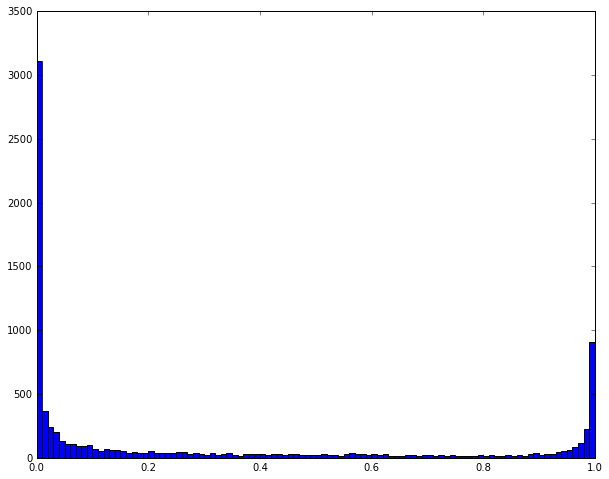

In [18]:
plt.hist(temp12.iloc[:,1], bins=100) 

In [8]:
seed= np.random.RandomState(9918)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for num, (train_index, val_index) in enumerate(spliter.split(train_X)):
    train_mean, train_std = transform_compute(train_X[train_index])
    print(train_mean,train_std)
train_mean, train_std = transform_compute(train_X)
print(train_mean,train_std)

[-20.65047216 -26.29580764 -23.4731399 ] [ 5.19811943  3.4044088   3.82018782]
[-20.69704394 -26.33726122 -23.51715258] [ 5.20568113  3.3850047   3.81330494]
[-20.68407176 -26.32931785 -23.50669481] [ 5.22365383  3.39790331  3.82706007]
[-20.59993459 -26.31542656 -23.45768057] [ 5.20183489  3.39804506  3.81525276]
[-20.64763873 -26.32569186 -23.4866653 ] [ 5.17425047  3.39204882  3.79961052]
[-20.65583096 -26.3207018  -23.48826638] [ 5.20083794  3.39551796  3.81515296]


In [45]:
#temp = temp11.iloc[:,:17]
temp.columns
#temp11.columns
temp.to_csv('resnet34_onlygoodretrain.csv',index=False)